<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/MRtoCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MR to CT

## Step 1: Setup the Environment

In [1]:
# Install required libraries
!pip install datasets

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

## Step 2: Load and Preprocess the MRI Dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

(…)-00000-of-00001-c08a401c53fe5312.parquet:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

(…)-00000-of-00001-44110b9df98c5585.parquet:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

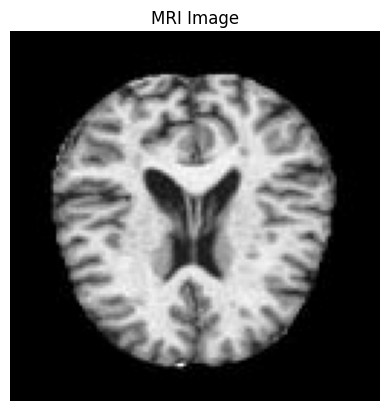

In [2]:
# Load the MRI dataset
mri_dataset = load_dataset('Falah/Alzheimer_MRI', split='train')

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 (as per the paper's input size)
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize (grayscale, so 1 channel)
])

# Custom Dataset class for MRI only
class MRIDataset(Dataset):
    def __init__(self, mri_dataset, transform=None):
        self.mri_dataset = mri_dataset
        self.transform = transform

    def __len__(self):
        return len(self.mri_dataset)

    def __getitem__(self, idx):
        mri_image = self.mri_dataset[idx]['image']  # Adjust key if needed
        if not isinstance(mri_image, Image.Image):
            mri_image = Image.fromarray(np.array(mri_image))

        if self.transform:
            mri_image = self.transform(mri_image)

        return mri_image

# Create dataset and dataloader
dataset = MRIDataset(mri_dataset, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Visualize a sample
mri_img = dataset[0]
plt.imshow(mri_img.squeeze(), cmap='gray')
plt.title("MRI Image")
plt.axis('off')
plt.show()

## Step 3: Define the cGAN Generator and Discriminator

In [3]:
# Residual Block (same as in the paper)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)  # Skip connection

# cGAN Generator (MRI -> CT)
class cGANGenerator(nn.Module):
    def __init__(self):
        super(cGANGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.res_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(9)])

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.res_blocks(x)
        x = self.decoder(x)
        return x

# cGAN Discriminator
class cGANDiscriminator(nn.Module):
    def __init__(self):
        super(cGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),  # Input: MRI + Generated CT
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, mri, ct):
        x = torch.cat([mri, ct], dim=1)  # Concatenate MRI and CT along channel dimension
        return self.model(x)

# Initialize models
G = cGANGenerator().to(device)
D = cGANDiscriminator().to(device)

## Step 4: Define Loss Functions and Optimizers

In [6]:
# Loss functions
adversarial_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# Heuristic losses for CT-like features
def edge_loss(fake_ct):
    # Apply Sobel filter to emphasize edges (CT images highlight bone structures)
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).to(device)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).to(device)
    sobel_x = sobel_x.view(1, 1, 3, 3)
    sobel_y = sobel_y.view(1, 1, 3, 3)

    edge_x = F.conv2d(fake_ct, sobel_x, padding=1)
    edge_y = F.conv2d(fake_ct, sobel_y, padding=1)
    edges = torch.sqrt(edge_x**2 + edge_y**2)
    return -torch.mean(edges)  # Encourage more edges (negative to maximize)

def contrast_loss(fake_ct):
    # Encourage high contrast (CT images have high contrast between bone and soft tissue)
    mean = torch.mean(fake_ct, dim=(2, 3), keepdim=True)
    variance = torch.mean((fake_ct - mean)**2, dim=(2, 3))
    return -torch.mean(variance)  # Encourage higher variance (negative to maximize)

# Optimizers
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Labels for adversarial loss (match Discriminator output size: [batch_size, 1, 14, 14])
# We'll define these dynamically in the training loop to handle varying batch sizes

## Step 5: Training Loop

In [8]:
# Training Loop
num_epochs = 5
lambda_edge = 10.0
lambda_contrast = 5.0

for epoch in range(num_epochs):
    for i, mri_images in enumerate(dataloader):
        mri_images = mri_images.to(device)
        batch_size = mri_images.size(0)  # Get the current batch size

        # Define labels dynamically to match Discriminator output size
        real_label = torch.ones((batch_size, 1, 14, 14)).to(device)  # Match Discriminator output: [batch_size, 1, 14, 14]
        fake_label = torch.zeros((batch_size, 1, 14, 14)).to(device)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Fake images
        fake_ct = G(mri_images)
        fake_pred = D(mri_images, fake_ct.detach())
        loss_D_fake = adversarial_loss(fake_pred, fake_label)

        # Since we don't have real CT, we'll use a heuristic "real" CT by transforming MRI
        with torch.no_grad():
            sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).to(device)
            sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).to(device)
            sobel_x = sobel_x.view(1, 1, 3, 3)
            sobel_y = sobel_y.view(1, 1, 3, 3)
            edge_x = F.conv2d(mri_images, sobel_x, padding=1)
            edge_y = F.conv2d(mri_images, sobel_y, padding=1)
            pseudo_ct = torch.sqrt(edge_x**2 + edge_y**2)
            pseudo_ct = torch.tanh(pseudo_ct)  # Normalize to [-1, 1]

        real_pred = D(mri_images, pseudo_ct)
        loss_D_real = adversarial_loss(real_pred, real_label)

        # Total Discriminator Loss
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        fake_ct = G(mri_images)
        fake_pred = D(mri_images, fake_ct)
        loss_G_adv = adversarial_loss(fake_pred, real_label)
        loss_G_edge = edge_loss(fake_ct)
        loss_G_contrast = contrast_loss(fake_ct)

        # Total Generator Loss
        loss_G = loss_G_adv + lambda_edge * loss_G_edge + lambda_contrast * loss_G_contrast
        loss_G.backward()
        optimizer_G.step()

        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(dataloader)}] "
                  f"Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}")

    # Save models
    torch.save(G.state_dict(), f'cGAN_G_epoch_{epoch+1}.pth')

Epoch [1/5] Batch [0/1280] Loss_D: 0.0010 Loss_G: -76.3344
Epoch [1/5] Batch [50/1280] Loss_D: 0.0006 Loss_G: -76.5042
Epoch [1/5] Batch [100/1280] Loss_D: 0.0005 Loss_G: -76.2578
Epoch [1/5] Batch [150/1280] Loss_D: 0.0004 Loss_G: -75.9869
Epoch [1/5] Batch [200/1280] Loss_D: 0.0003 Loss_G: -75.7691
Epoch [1/5] Batch [250/1280] Loss_D: 0.0002 Loss_G: -75.6375
Epoch [1/5] Batch [300/1280] Loss_D: 0.0002 Loss_G: -75.5047
Epoch [1/5] Batch [350/1280] Loss_D: 0.0002 Loss_G: -75.3415
Epoch [1/5] Batch [400/1280] Loss_D: 0.0001 Loss_G: -75.2132
Epoch [1/5] Batch [450/1280] Loss_D: 0.0001 Loss_G: -75.0680
Epoch [1/5] Batch [500/1280] Loss_D: 0.0001 Loss_G: -74.9539
Epoch [1/5] Batch [550/1280] Loss_D: 0.0001 Loss_G: -74.8735
Epoch [1/5] Batch [600/1280] Loss_D: 0.0001 Loss_G: -74.7916
Epoch [1/5] Batch [650/1280] Loss_D: 0.0001 Loss_G: -74.6320
Epoch [1/5] Batch [700/1280] Loss_D: 0.0001 Loss_G: -74.5880
Epoch [1/5] Batch [750/1280] Loss_D: 0.0001 Loss_G: -74.4924
Epoch [1/5] Batch [800/1280

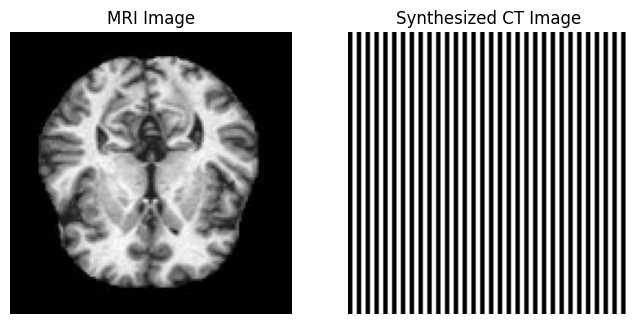

In [9]:
# Test the Generator
G.eval()
with torch.no_grad():
    mri_images = next(iter(dataloader))
    mri_images = mri_images.to(device)
    fake_ct = G(mri_images)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(mri_images[0].cpu().squeeze(), cmap='gray')
    plt.title("MRI Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(fake_ct[0].cpu().squeeze(), cmap='gray')
    plt.title("Synthesized CT Image")
    plt.axis('off')
    plt.show()